In [ ]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

print("Tamaño del set de entrenamiento:", len(train_data))
print("Tamaño del set de prueba:", len(test_data))


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.2MB/s]

Tamaño del set de entrenamiento: 60000
Tamaño del set de prueba: 10000


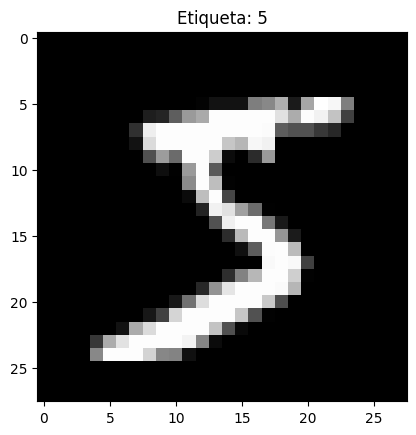

In [ ]:
import matplotlib.pyplot as plt

image, label = train_data[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Etiqueta: {label}")
plt.show()


In [ ]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(train_data))
val_size   = len(train_data) - train_size
train_subset, val_subset = random_split(train_data, [train_size, val_size])

batch_size = 64

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=batch_size)
test_loader  = DataLoader(test_data, batch_size=batch_size)


In [ ]:
import torch.nn as nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validación
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            val_loss += criterion(output, labels).item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    accuracy = correct / total

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {accuracy:.4f}")


Epoch 1/10, Train Loss: 0.4451, Val Loss: 0.2696, Val Accuracy: 0.9171
Epoch 2/10, Train Loss: 0.2244, Val Loss: 0.1628, Val Accuracy: 0.9485
Epoch 3/10, Train Loss: 0.1795, Val Loss: 0.1517, Val Accuracy: 0.9543
Epoch 4/10, Train Loss: 0.1568, Val Loss: 0.1413, Val Accuracy: 0.9587
Epoch 5/10, Train Loss: 0.1412, Val Loss: 0.1244, Val Accuracy: 0.9648
Epoch 6/10, Train Loss: 0.1311, Val Loss: 0.1136, Val Accuracy: 0.9680
Epoch 7/10, Train Loss: 0.1250, Val Loss: 0.1242, Val Accuracy: 0.9640
Epoch 8/10, Train Loss: 0.1112, Val Loss: 0.1087, Val Accuracy: 0.9728
Epoch 9/10, Train Loss: 0.1047, Val Loss: 0.1155, Val Accuracy: 0.9671
Epoch 10/10, Train Loss: 0.1029, Val Loss: 0.1091, Val Accuracy: 0.9682


In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
X = torch.stack([train_data[i][0] for i in range(len(train_data))])
y = torch.tensor([train_data[i][1] for i in range(len(train_data))])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        output = model(images)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu())
        all_labels.extend(labels)

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.95      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.96      0.98      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.95      0.97      0.96       974
           9       0.98      0.93      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



<Axes: >

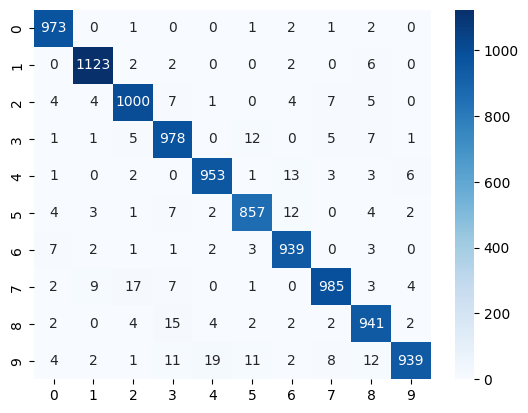

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


In [ ]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)

# Congelar todas las capas
for param in model_ft.parameters():
    param.requires_grad = False

# Reemplazar capa final
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)  # 10 clases

model_ft.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
optimizer = optim.Adam(model_ft.fc.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Entrenamiento similar al anterior pero solo con la capa final


In [ ]:
for param in model_ft.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model_ft.parameters(), lr=1e-5)


In [ ]:
torch.save(model.state_dict(), "modelo_final.pth")


In [ ]:
model.load_state_dict(torch.load("modelo_final.pth"))
model.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

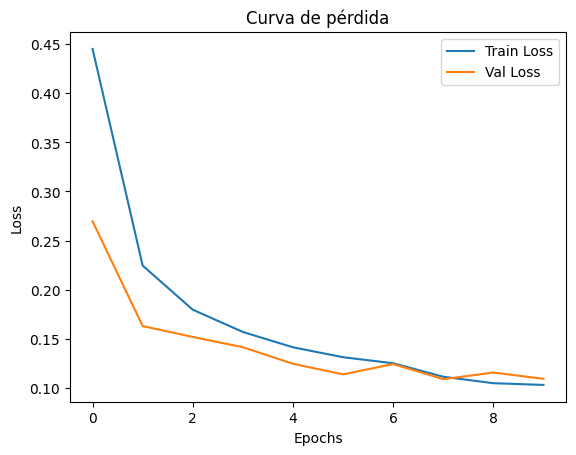

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Curva de pérdida")
plt.savefig("curva_loss.png")  # Guardar imagen
plt.show()


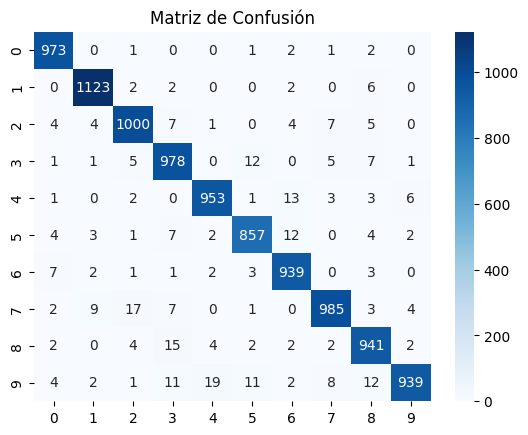

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.savefig("confusion_matrix.png")
plt.show()

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transforma MNIST para que sea compatible con ResNet (3 canales, 224x224)
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # de 1 a 3 canales
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normaliza para los 3 canales
])

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform_resnet)
test_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform_resnet)

from torch.utils.data import random_split

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_subset, val_subset = random_split(train_data, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=True)

# Congelar todas las capas excepto la última
for param in model_ft.parameters():
    param.requires_grad = False

# Reemplazar la capa final con una que tenga 10 salidas (MNIST)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft.to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.fc.parameters(), lr=1e-4)


In [ ]:
epochs = 5
for epoch in range(epochs):
    model_ft.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_ft(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validación
    model_ft.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_ft(images)
            val_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Val Acc: {accuracy:.4f}")


Epoch 1/5, Loss: 1.2781, Val Acc: 0.8829
Epoch 2/5, Loss: 0.5774, Val Acc: 0.9177
Epoch 3/5, Loss: 0.4058, Val Acc: 0.9308
Epoch 4/5, Loss: 0.3272, Val Acc: 0.9389
Epoch 5/5, Loss: 0.2821, Val Acc: 0.9447


              precision    recall  f1-score   support

           0     0.9358    0.9816    0.9582       980
           1     0.9715    0.9903    0.9808      1135
           2     0.9119    0.9128    0.9123      1032
           3     0.9028    0.9287    0.9156      1010
           4     0.9593    0.9603    0.9598       982
           5     0.9157    0.9013    0.9085       892
           6     0.9588    0.9468    0.9527       958
           7     0.9481    0.9416    0.9449      1028
           8     0.9624    0.9456    0.9539       974
           9     0.9687    0.9197    0.9436      1009

    accuracy                         0.9437     10000
   macro avg     0.9435    0.9429    0.9430     10000
weighted avg     0.9439    0.9437    0.9437     10000



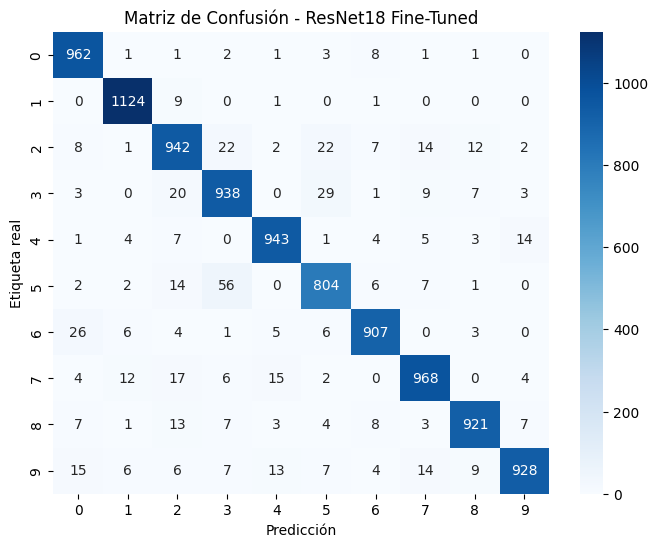

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model_ft.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Métricas
print(classification_report(all_labels, all_preds, digits=4))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - ResNet18 Fine-Tuned")
plt.show()


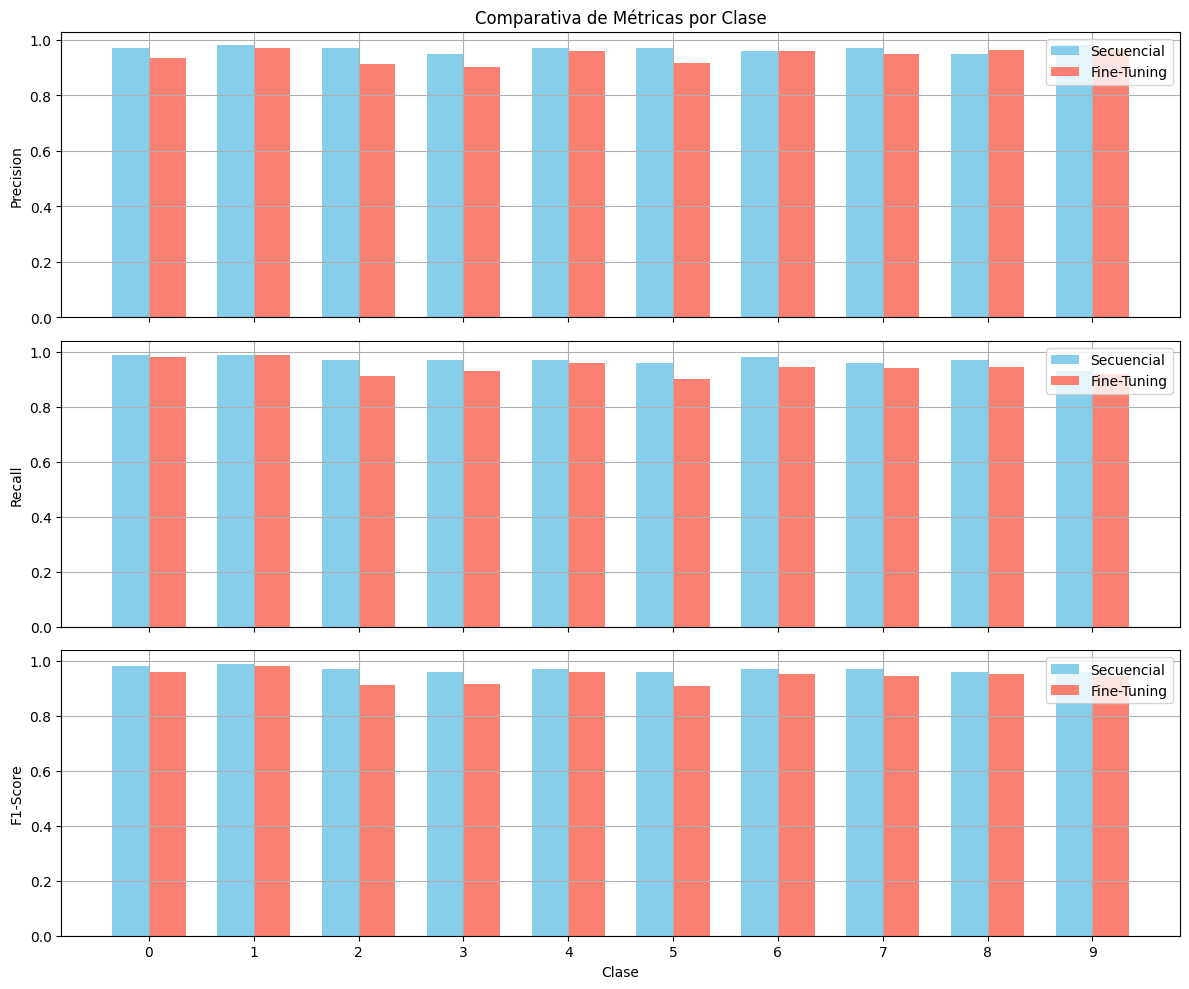

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Clases del 0 al 9
classes = [str(i) for i in range(10)]

# Métricas del modelo secuencial
seq_precision = [0.97, 0.98, 0.97, 0.95, 0.97, 0.97, 0.96, 0.97, 0.95, 0.98]
seq_recall    = [0.99, 0.99, 0.97, 0.97, 0.97, 0.96, 0.98, 0.96, 0.97, 0.93]
seq_f1        = [0.98, 0.99, 0.97, 0.96, 0.97, 0.96, 0.97, 0.97, 0.96, 0.96]

# Métricas del modelo fine-tuned
ft_precision = [0.9358, 0.9715, 0.9119, 0.9028, 0.9593, 0.9157, 0.9588, 0.9481, 0.9624, 0.9687]
ft_recall    = [0.9816, 0.9903, 0.9128, 0.9287, 0.9603, 0.9013, 0.9468, 0.9416, 0.9456, 0.9197]
ft_f1        = [0.9582, 0.9808, 0.9123, 0.9156, 0.9598, 0.9085, 0.9527, 0.9449, 0.9539, 0.9436]

# Configuración de ancho de barras
x = np.arange(len(classes))
width = 0.35

# Crear figura y subgráficas
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Precision
ax[0].bar(x - width/2, seq_precision, width, label='Secuencial', color='skyblue')
ax[0].bar(x + width/2, ft_precision,  width, label='Fine-Tuning', color='salmon')
ax[0].set_ylabel('Precision')
ax[0].set_title('Comparativa de Métricas por Clase')
ax[0].legend()
ax[0].grid(True)

# Recall
ax[1].bar(x - width/2, seq_recall, width, label='Secuencial', color='skyblue')
ax[1].bar(x + width/2, ft_recall,  width, label='Fine-Tuning', color='salmon')
ax[1].set_ylabel('Recall')
ax[1].legend()
ax[1].grid(True)

# F1-Score
ax[2].bar(x - width/2, seq_f1, width, label='Secuencial', color='skyblue')
ax[2].bar(x + width/2, ft_f1,  width, label='Fine-Tuning', color='salmon')
ax[2].set_ylabel('F1-Score')
ax[2].set_xlabel('Clase')
ax[2].set_xticks(x)
ax[2].set_xticklabels(classes)
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()
